In [1]:
# Importing the required packages
import calliope
import pandas as pd
from spores_algorithm import run_spores
from plotting_utilities import plot_dispatch, plot_capacity, plot_network
import matplotlib.pyplot as plt

import glob
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial.distance import cdist
import numpy as np
import xarray as xr

calliope.set_log_verbosity('INFO', include_solver_output=False) # Defines how much information you get 
                                                               #from the machine as the model gets built and run

Aggregate source capacities from all SPORE NetCDF files into a single DataFrame, with each row representing a SPORE and columns representing technology capacities.

In [2]:
# List all the SPORE files (adjust path pattern as needed)
spore_files = glob.glob('results/spores/*.nc') # Assuming SPORE files are stored in 'results/spores/' directory

# Initialize an empty list to hold the aggregated data for each SPORE
aggregated_data_list = []

# Iterate over each SPORE file
for file in spore_files:
    # Open the NetCDF file
    data = xr.open_dataset(file)
    
    # Convert source capacities to DataFrame
    data_source = data['flow_cap'].to_dataframe().reset_index()
    
    # Filter out any "_to_" techs and drop NaN values in flow_cap
    data_source = data_source[~data_source['techs'].str.contains(r'_to_', regex=True)]
    data_source = data_source.dropna(subset=['flow_cap'])
    
    # Aggregate the source capacities by tech
    aggregated_source_cap = data_source.groupby('techs')['flow_cap'].sum().reset_index()
    
    # Convert the aggregated source capacities into a series with tech as the index
    aggregated_series = aggregated_source_cap.set_index('techs')['flow_cap']
    
    spore_name = file.split('/')[-1].split('.')[0]  # Extracting 'maxnuc_spore_1' from the file name
    aggregated_series.name = spore_name  # Name the row by the SPORE name

    # Append the aggregated data (this will form the rows in the final matrix)
    aggregated_data_list.append(aggregated_series)

# Combine all SPORE aggregated data into a single DataFrame (with each SPORE as a row)
aggregated_matrix = pd.concat(aggregated_data_list, axis=1).T

# Set the column names to be the techs
aggregated_matrix.columns = aggregated_source_cap['techs']

# Show the resulting matrix
aggregated_matrix

techs,battery,bioenergy,ccgt,coal,curtailment,demand_power,export_power,hydrogen_power_storage,import_power,lost_load,nuclear,solar_pv,wind_offshore,wind_onshore
spores\maxbat_spore_1,1.108870e+03,7509.179314,1650.404701,0.004470,0.085777,17161.0,11827.837197,0.000047,3230.094173,3.721065e-09,485.001462,24359.000237,4757.000052,14589.138430
spores\maxbat_spore_2,1.108548e+03,7525.292952,1636.441691,0.026754,0.194148,17161.0,11816.827779,0.000263,3552.789002,2.090733e-08,485.008277,24359.001278,4757.000067,14588.136157
spores\maxbat_spore_3,1.108776e+03,7518.175739,1639.712199,0.009444,0.056972,17161.0,11976.967671,0.000102,3879.994531,7.454966e-09,485.003138,24359.000364,4757.000072,14589.019002
spores\maxbat_spore_4,1.108130e+03,7585.193823,1594.609839,0.595025,157.506252,17161.0,11857.001919,0.006690,3308.526427,6.184824e-07,485.203908,24359.043372,4757.013806,14508.488186
spores\maxbat_spore_5,1.107102e+03,7667.706230,1545.354407,0.001152,22.275690,17161.0,11958.235120,0.000013,3364.330085,0.000000e+00,485.000389,24359.000057,4757.000019,14306.207486
spores\maxbio_spore_1,1.863829e+02,12000.000000,1955.943479,1036.193196,4518.595320,17161.0,8270.366091,9.140912,933.737436,9.668447e-04,875.982205,24487.176173,4765.777058,10647.727673
spores\maxbio_spore_2,2.072655e+00,12000.000000,1104.233508,801.075087,6323.956238,17161.0,7134.157127,11.955165,2096.494862,1.439780e-03,959.764994,24452.171259,4791.484913,11412.609175
spores\maxbio_spore_3,2.891522e+01,12000.000613,5768.405081,93.615661,422.567068,17161.0,9829.532563,3.969264,3054.987696,2.387756e-04,607.391149,24361.819605,4752.579095,12197.660024
spores\maxbio_spore_4,1.798627e+01,12000.000727,44.460796,103.118463,93.921342,17161.0,7242.231255,2.253238,8886.751504,1.311059e-04,749.999816,24359.735455,4752.806846,6957.617694
spores\maxbio_spore_5,1.482228e+00,11999.999999,0.874183,1.666892,3945.711680,17161.0,7750.879925,1.482863,5575.236192,2.155949e-03,789.762479,24359.008648,4748.162782,6953.006865


Standardize the aggregated technology capacity data using `StandardScaler` to prepare for clustering.

In [3]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
matrix_scaled = scaler.fit_transform(aggregated_matrix)  # Normalize across all technologies

Compute and plot the distances to the 5th nearest neighbor for each SPORE configuration to help tune DBSCAN clustering parameters.

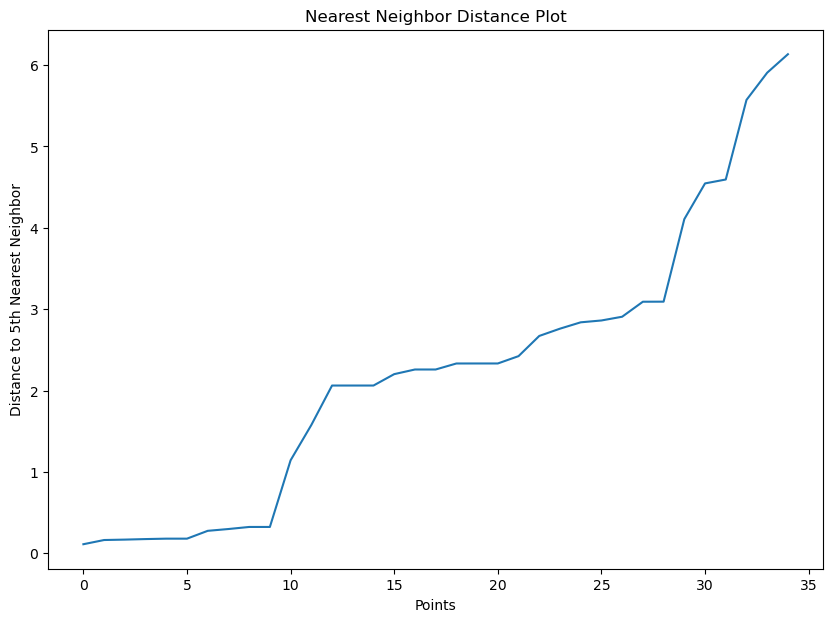

In [4]:
from sklearn.neighbors import NearestNeighbors

# Calculate the nearest neighbor distances
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(matrix_scaled)
distances, indices = neighbors_fit.kneighbors(matrix_scaled)

# Sort the distances in ascending order
distances = np.sort(distances[:,4], axis=0)

# Plot the distances
plt.figure(figsize=(10, 7))
plt.plot(distances)
plt.title('Nearest Neighbor Distance Plot')
plt.xlabel('Points')
plt.ylabel('Distance to 5th Nearest Neighbor')
plt.show()


Apply DBSCAN clustering to the standardized data and print the number of clusters found.

In [5]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN with eps=0.5 and min_samples=5
db = DBSCAN(eps=0.5, min_samples=5)
db_labels = db.fit_predict(matrix_scaled)

# Check the number of distinct clusters
print(f"Number of clusters found by DBSCAN: {len(set(db_labels)) - (1 if -1 in db_labels else 0)}")

Number of clusters found by DBSCAN: 2


Run DBSCAN clustering with specified parameters and add the resulting cluster labels to the aggregated matrix.

In [6]:
from sklearn.cluster import DBSCAN

# eps: The maximum distance between two points for them to be considered as part of the same neighborhood. 
# min_samples: The number of points required to form a dense region (a cluster).
dbscan = DBSCAN(eps=0.5, min_samples=3)

cluster_labels = dbscan.fit_predict(matrix_scaled)

# Add the DBSCAN cluster labels to the aggregated_matrix
aggregated_matrix['Cluster_DBSCAN'] = cluster_labels


Display the number of SPORE configurations in each DBSCAN cluster.

In [7]:
# Check the number of points in each cluster
print(aggregated_matrix['Cluster_DBSCAN'].value_counts())

Cluster_DBSCAN
-1    25
 0     5
 1     5
Name: count, dtype: int64


Reduce the standardized data to two principal components using PCA and plot the DBSCAN clusters in 2D.

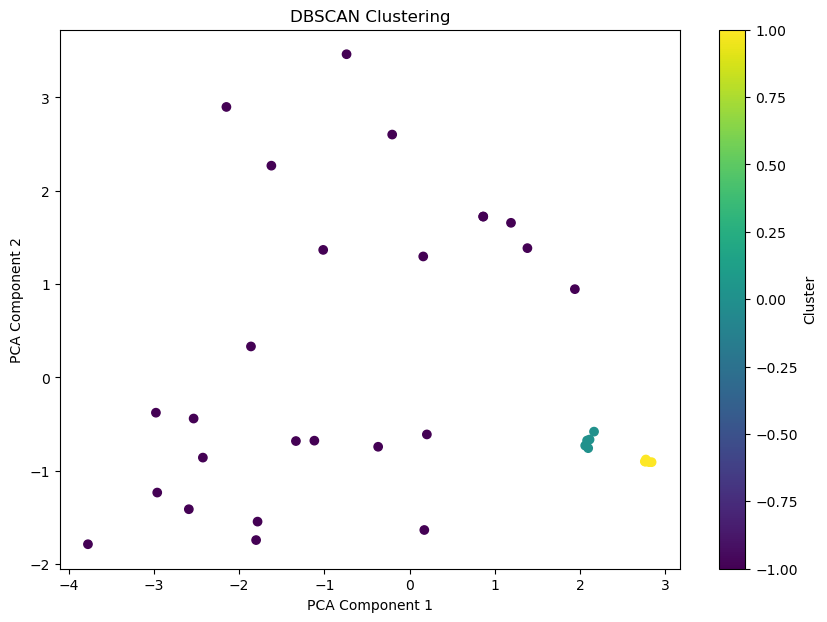

In [8]:
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
pca_result = pca.fit_transform(matrix_scaled)

# Plot the DBSCAN clusters in 2D
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=aggregated_matrix['Cluster_DBSCAN'], cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


Summarize the count of SPORE categories within each cluster by extracting general SPORE types and grouping by cluster and category.

In [9]:
# Dynamically extract the general SPORE category from the 'techs' index by splitting the names
aggregated_matrix_count = aggregated_matrix.copy()

aggregated_matrix_count['spore_category_general'] = aggregated_matrix_count.index.to_series().apply(lambda x: x.split('_spore')[0])

# Now, group by 'Cluster' and 'spore_category_general' and count the occurrences
cluster_spore_count = aggregated_matrix_count.groupby(['Cluster_DBSCAN', 'spore_category_general']).size().unstack(fill_value=0)

# Show the resulting table
cluster_spore_count

spore_category_general,spores\maxbat,spores\maxbio,spores\maxhyd,spores\maxnuc,spores\minbat,spores\minhyd,spores\minnuc
Cluster_DBSCAN,,,,,,,
-1,0,5,5,0,5,5,5
0,5,0,0,0,0,0,0
1,0,0,0,5,0,0,0


Remove noise points (outliers) from the aggregated matrix by excluding configurations labeled as noise by DBSCAN.

In [10]:
# remove the noise data points
aggregated_matrix = aggregated_matrix[aggregated_matrix['Cluster_DBSCAN'] != -1]

Calculate and display the mean technology capacities for each cluster.

In [11]:
# Group by 'Cluster' and calculate the mean for each technology
cluster_summary = aggregated_matrix.groupby('Cluster_DBSCAN').mean()

# Show the resulting cluster summary
cluster_summary


techs,battery,bioenergy,ccgt,coal,curtailment,demand_power,export_power,hydrogen_power_storage,import_power,lost_load,nuclear,solar_pv,wind_offshore,wind_onshore
Cluster_DBSCAN,,,,,,,,,,,,,,
0,1108.285205,7561.109612,1613.304567,0.127369,36.023768,17161.0,11887.373937,0.001423,3467.146844,1.301131e-07,485.043435,24359.009062,4757.002803,14516.197853
1,0.001461,1474.817629,1822.534281,0.012473,452.957618,17161.0,11817.998019,0.000150,3703.556905,7.857804e-09,6367.837927,24359.000226,4757.000137,14592.103090


Plot a bar chart showing the average technology capacities for each cluster.

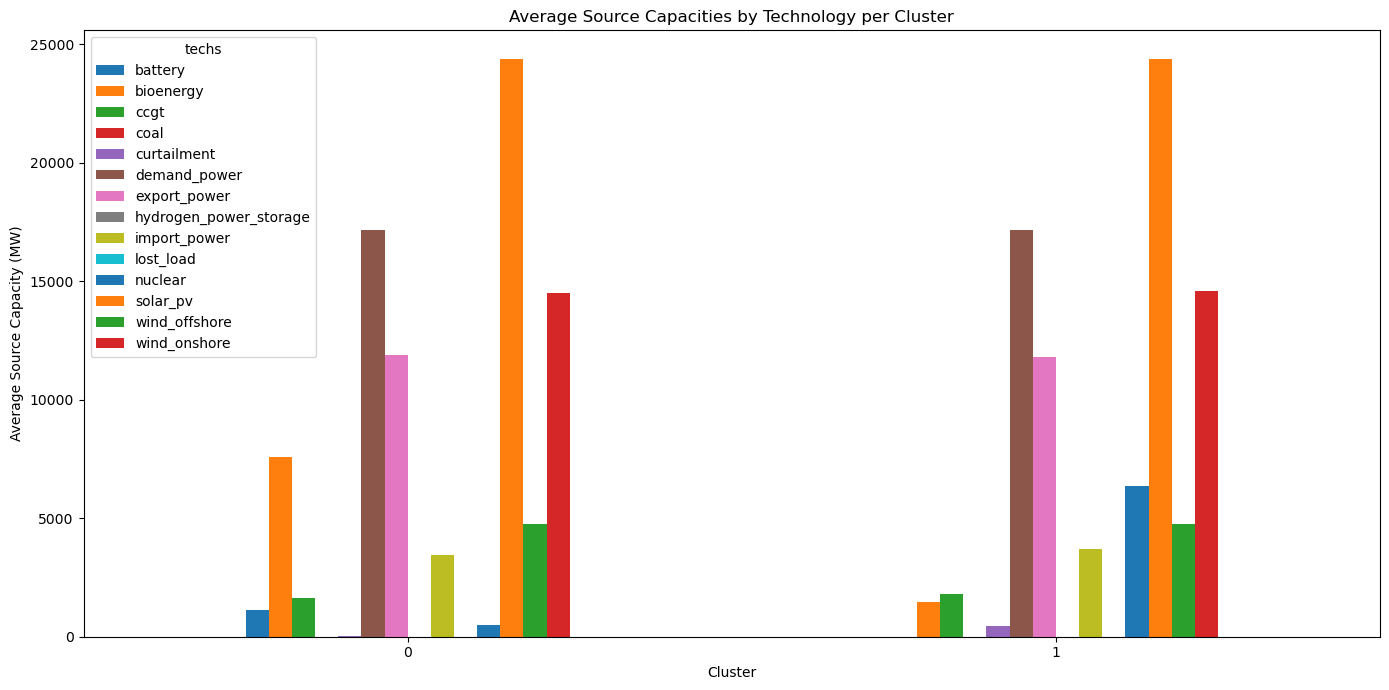

In [12]:
# Plot bar chart for each cluster
cluster_summary.plot(kind='bar', figsize=(14, 7))

plt.title('Average Source Capacities by Technology per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Source Capacity (MW)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Identify and plot the representative configuration (closest to centroid) for each cluster, showing technology capacities for each representative.

Cluster 0 - Shape of cluster_configs: (5, 14)
Cluster 1 - Shape of cluster_configs: (5, 14)
Representative configurations: ['spores\\maxbat_spore_2', 'spores\\maxnuc_spore_5']


<Figure size 1400x700 with 0 Axes>

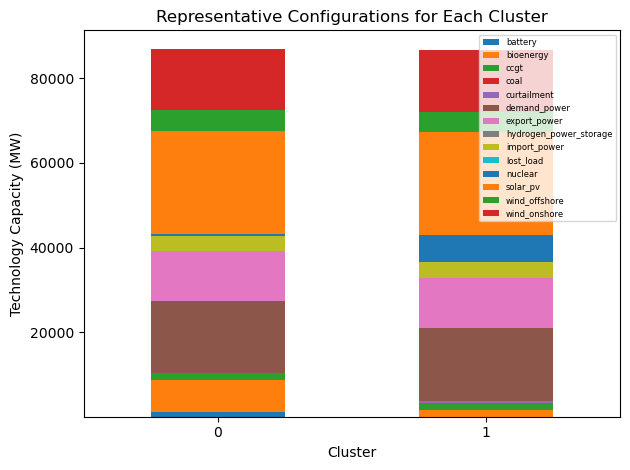

In [13]:
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial.distance import cdist
import numpy as np

# Assuming 'aggregated_matrix' is your DataFrame with the 'Cluster' and technology columns
# 1. Compute the centroids of each cluster (mean of each technology in each cluster)
cluster_centroids = aggregated_matrix.groupby('Cluster_DBSCAN').mean()


# 2. Find the configuration closest to the centroid for each cluster
representative_configs = []

for cluster in aggregated_matrix['Cluster_DBSCAN'].unique():
    # Get the configurations in the current cluster
    cluster_configs = aggregated_matrix[aggregated_matrix['Cluster_DBSCAN'] == cluster].drop(columns=['Cluster_DBSCAN'])

    # Print the shape of the data to verify it's correct
    print(f"Cluster {cluster} - Shape of cluster_configs: {cluster_configs.shape}")

    # Calculate the centroid for the current cluster
    centroid = cluster_centroids.loc[cluster]

    # Compute the Euclidean distances between each configuration and the centroid
    distances = cdist(cluster_configs, centroid.values.reshape(1, -1), metric='euclidean')

    # Get the index of the closest configuration (minimum distance)
    closest_index = np.argmin(distances)
    representative_config = cluster_configs.iloc[closest_index].name

    # Append the representative configuration's index
    representative_configs.append(representative_config)

# Print the representative configurations' indices
print(f"Representative configurations: {representative_configs}")

# 3. Retrieve the representative configurations from the 'aggregated_matrix'
df_representative_configs = aggregated_matrix.loc[representative_configs]

# 4. Plot the representative configurations (one bar plot per cluster)
plt.figure(figsize=(14, 7))
df_representative_configs.drop(columns=['Cluster_DBSCAN']).plot(kind='bar', stacked=True)

# Add titles and labels
plt.title('Representative Configurations for Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Technology Capacity (MW)')
plt.xticks(range(len(df_representative_configs)), labels=df_representative_configs['Cluster_DBSCAN'], rotation=0)
plt.tight_layout()
plt.legend(loc='upper right', prop={'size': 6})
plt.show()

Extract systemwide levelized cost and capacity factor metrics for each SPORE from NetCDF files and organize them into a DataFrame indexed by SPORE and technology.

In [14]:
import glob
import xarray as xr
import pandas as pd

# List all the SPORE files (adjust path pattern as needed)
spore_files = glob.glob('results/spores/*.nc')  # Adjust this if needed

# Initialize an empty list to hold the performance metrics for each SPORE
performance_metrics_list = []

# Iterate over each SPORE file
for file in spore_files:
    # Open the NetCDF file
    data = xr.open_dataset(file)
    
    # Extract systemwide levelized cost (LCOE)
    data_sys_LCOE = data['systemwide_levelised_cost'].to_dataframe().reset_index()
    data_sys_LCOE = data_sys_LCOE[data_sys_LCOE['costs'] == 'monetary']  # Filter for monetary costs
    data_sys_LCOE = data_sys_LCOE[data_sys_LCOE['techs'] != 'lost_load']  # Exclude 'lost_load'
    data_sys_LCOE = data_sys_LCOE[~data_sys_LCOE['techs'].str.contains(r'_to_', regex=True)]  # Exclude techs with '_to_'
    data_sys_LCOE = data_sys_LCOE.drop(columns=['costs', 'carriers', 'spores'])  # Drop unnecessary columns
    data_sys_LCOE = data_sys_LCOE[(data_sys_LCOE['techs'] != 'curtailment')&(data_sys_LCOE['techs'] != 'demand_power')&(data_sys_LCOE['techs'] != 'export_power')] # Exclude 'curtailment'
    
    # Extract systemwide capacity factor
    data_sys_cap = data['systemwide_capacity_factor'].to_dataframe().reset_index()
    data_sys_cap = data_sys_cap[~data_sys_cap['techs'].str.contains(r'_to_', regex=True)]  # Exclude techs with '_to_'
    data_sys_cap = data_sys_cap.drop(columns=['carriers', 'spores'])  # Drop unnecessary columns
    data_sys_cap = data_sys_cap[(data_sys_cap['techs'] != 'lost_load') & (data_sys_cap['techs'] != 'curtailment')]
    data_sys_cap = data_sys_cap[(data_sys_cap['techs'] != 'demand_power') & (data_sys_cap['techs'] != 'export_power')]  # Exclude 'demand_power' and 'export_power'
    
    # Extract the SPORE name from the file name (e.g., 'maxnuc_spore_1')
    spore_name = file.split('/')[-1].split('.')[0]  # Extracting 'maxnuc_spore_1' from the file name
    
    # Merge the data for the current SPORE (levelized cost and capacity factor)
    performance_metrics_df = pd.DataFrame({
        'systemwide_levelized_cost': data_sys_LCOE.set_index('techs')['systemwide_levelised_cost'],
        'systemwide_capacity_factor': data_sys_cap.set_index('techs')['systemwide_capacity_factor']
    })
    
    # Add the 'techs' column back to the DataFrame for proper indexing
    performance_metrics_df['techs'] = performance_metrics_df.index
    
    # Add the SPORE name as a column for identification
    performance_metrics_df['spore_name'] = spore_name
    
    # Append the performance metrics for this SPORE to the list
    performance_metrics_list.append(performance_metrics_df)

# Combine all performance metrics data into a single DataFrame (with each SPORE as a row)
performance_metrics_matrix = pd.concat(performance_metrics_list, axis=0)

# Reorganize the matrix with 'techs' as the index and 'systemwide_levelized_cost' and 'systemwide_capacity_factor' as columns
performance_metrics_matrix = performance_metrics_matrix.set_index(['spore_name', 'techs'])

# Show the resulting performance metrics matrix
performance_metrics_matrix # Display the first few rows of the matrix for verification

systemwide_levelized_cost  \
spore_name            techs                                               
spores\maxbat_spore_1 battery                                  2.932958   
                      bioenergy                                0.048669   
                      ccgt                                     0.086268   
                      coal                                     0.103516   
                      hydrogen_power_storage                  12.045798   
...                                                                 ...   
spores\minnuc_spore_5 import_power                             0.100000   
                      nuclear                                  0.124775   
                      solar_pv                                 0.314523   
                      wind_offshore                            0.055898   
                      wind_onshore                             0.038879   

                                              systemwide_capacity_factor  
spore_name            techs                                               
spores\maxbat_spore_1 battery                                   0.120896  
                      bioenergy                                 1.000000  
                      ccgt                                      0.294664  
                      coal                                      0.608415  
                      hydrogen_power_storage                    0.307657  
...                                                                  ...  
spores\minnuc_spore_5 import_power                              0.378354  
                      nuclear                                   0.905733  
                      solar_pv                                  0.025265  
                      wind_offshore                             0.383397  
                      wind_onshore                              0.372848  

[350 rows x 2 columns]

For each representative configuration, extract and display the systemwide levelized cost and capacity factor for all technologies.

In [15]:
# Initialize two lists to hold the levelized cost and capacity factor for each representative configuration
levelized_cost_list = []
capacity_factor_list = []

# Iterate over each representative configuration (row in df_representative_configs)
for config in df_representative_configs.index:
    spore_name = config  # SPORE name as 'techs' holds the SPORE name
    
    # Extract the systemwide levelized cost for each SPORE configuration
    levelized_cost = performance_metrics_matrix.xs(spore_name, level='spore_name')['systemwide_levelized_cost'] if spore_name in performance_metrics_matrix.index.get_level_values('spore_name') else None
    capacity_factor = performance_metrics_matrix.xs(spore_name, level='spore_name')['systemwide_capacity_factor'] if spore_name in performance_metrics_matrix.index.get_level_values('spore_name') else None
    
    # Append the results as rows in the respective lists
    levelized_cost_list.append(levelized_cost)
    capacity_factor_list.append(capacity_factor)

# Convert the lists into DataFrames
df_levelized_cost = pd.DataFrame(levelized_cost_list, columns=performance_metrics_matrix.index.get_level_values('techs').unique(), index=df_representative_configs.index)
df_capacity_factor = pd.DataFrame(capacity_factor_list, columns=performance_metrics_matrix.index.get_level_values('techs').unique(), index=df_representative_configs.index)

# Display the resulting DataFrames
print("Systemwide Levelized Cost Table:")
print(df_levelized_cost)
print("\nSystemwide Capacity Factor Table:")
print(df_capacity_factor)

Systemwide Levelized Cost Table:
techs                   battery  bioenergy      ccgt      coal  \
spores\maxbat_spore_2  2.925124   0.048669  0.086403  0.107724   
spores\maxnuc_spore_5  0.781615   0.048669  0.085310  0.099983   

techs                  hydrogen_power_storage  import_power   nuclear  \
spores\maxbat_spore_2               12.665025           0.1  0.114334   
spores\maxnuc_spore_5               18.078201           0.1  0.114333   

techs                  solar_pv  wind_offshore  wind_onshore  
spores\maxbat_spore_2  0.314525       0.055729      0.034719  
spores\maxnuc_spore_5  0.314525       0.055729      0.034719  

Systemwide Capacity Factor Table:
techs                   battery  bioenergy      ccgt      coal  \
spores\maxbat_spore_2  0.121220   0.999998  0.293637  0.575440   
spores\maxnuc_spore_5  0.457195   1.000000  0.302158  0.639175   

techs                  hydrogen_power_storage  import_power   nuclear  \
spores\maxbat_spore_2                0.293946      0

Display the DataFrame of systemwide levelized costs for representative configurations.

In [16]:
df_levelized_cost

techs,battery,bioenergy,ccgt,coal,hydrogen_power_storage,import_power,nuclear,solar_pv,wind_offshore,wind_onshore
spores\maxbat_spore_2,2.925124,0.048669,0.086403,0.107724,12.665025,0.1,0.114334,0.314525,0.055729,0.034719
spores\maxnuc_spore_5,0.781615,0.048669,0.085310,0.099983,18.078201,0.1,0.114333,0.314525,0.055729,0.034719


Display the DataFrame of systemwide capacity factors for representative configurations.

In [17]:
df_capacity_factor

techs,battery,bioenergy,ccgt,coal,hydrogen_power_storage,import_power,nuclear,solar_pv,wind_offshore,wind_onshore
spores\maxbat_spore_2,0.121220,0.999998,0.293637,0.575440,0.293946,0.056502,0.999992,0.025265,0.384563,0.419552
spores\maxnuc_spore_5,0.457195,1.000000,0.302158,0.639175,0.193594,0.079858,1.000000,0.025265,0.384564,0.419551
